In [1]:
import cv2
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D,Input,MaxPooling2D,Dropout,Flatten,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


# Facial landmark detection with Keras CNN

In this kernel I used Keras to make a simple convolutional neural network (CNN) to detect the eyes, nose and mouth from this database.

In [2]:
# load the dataset
images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)
landmarks = pd.read_csv('./dataset/archive/facial_keypoints.csv')

landmarks_pos = landmarks.columns.tolist()
print(landmarks.isnull().sum())

/tmp/ipykernel_8451/1253735854.py:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

I will only select the x and y of the eyes center, nose tip and mouth center, because these values are most avaiable. This gives 7000 images and X and Y are build to fit Keras format. Y is rescaled between 0 and 1.

In [3]:
index_nn = np.nonzero(landmarks.left_eye_center_x.notna() & landmarks.right_eye_center_x.notna())[0]

pic_shape = images.shape[1]
m = index_nn.shape[0]
X = np.zeros((m,pic_shape,pic_shape,1))
Y = np.zeros((m,12))

X[:,:,:,0]=images[index_nn,:,:]/255.0

Y[:,0]=landmarks.left_eye_center_x[index_nn]
Y[:,1]=landmarks.left_eye_center_y[index_nn]
Y[:,2]=landmarks.right_eye_center_x[index_nn]
Y[:,3]=landmarks.right_eye_center_y[index_nn]

Y[:,4]=landmarks.left_eye_inner_corner_x[index_nn]
Y[:,5]=landmarks.left_eye_inner_corner_y[index_nn]
Y[:,6]=landmarks.left_eye_outer_corner_x[index_nn]
Y[:,7]=landmarks.left_eye_outer_corner_y[index_nn]

Y[:,8]=landmarks.right_eye_inner_corner_x[index_nn]
Y[:,9]=landmarks.right_eye_inner_corner_y[index_nn]
Y[:,10]=landmarks.right_eye_outer_corner_x[index_nn]
Y[:,11]=landmarks.right_eye_outer_corner_y[index_nn]

print('# selected images = %d' % m)

# selected images = 7033


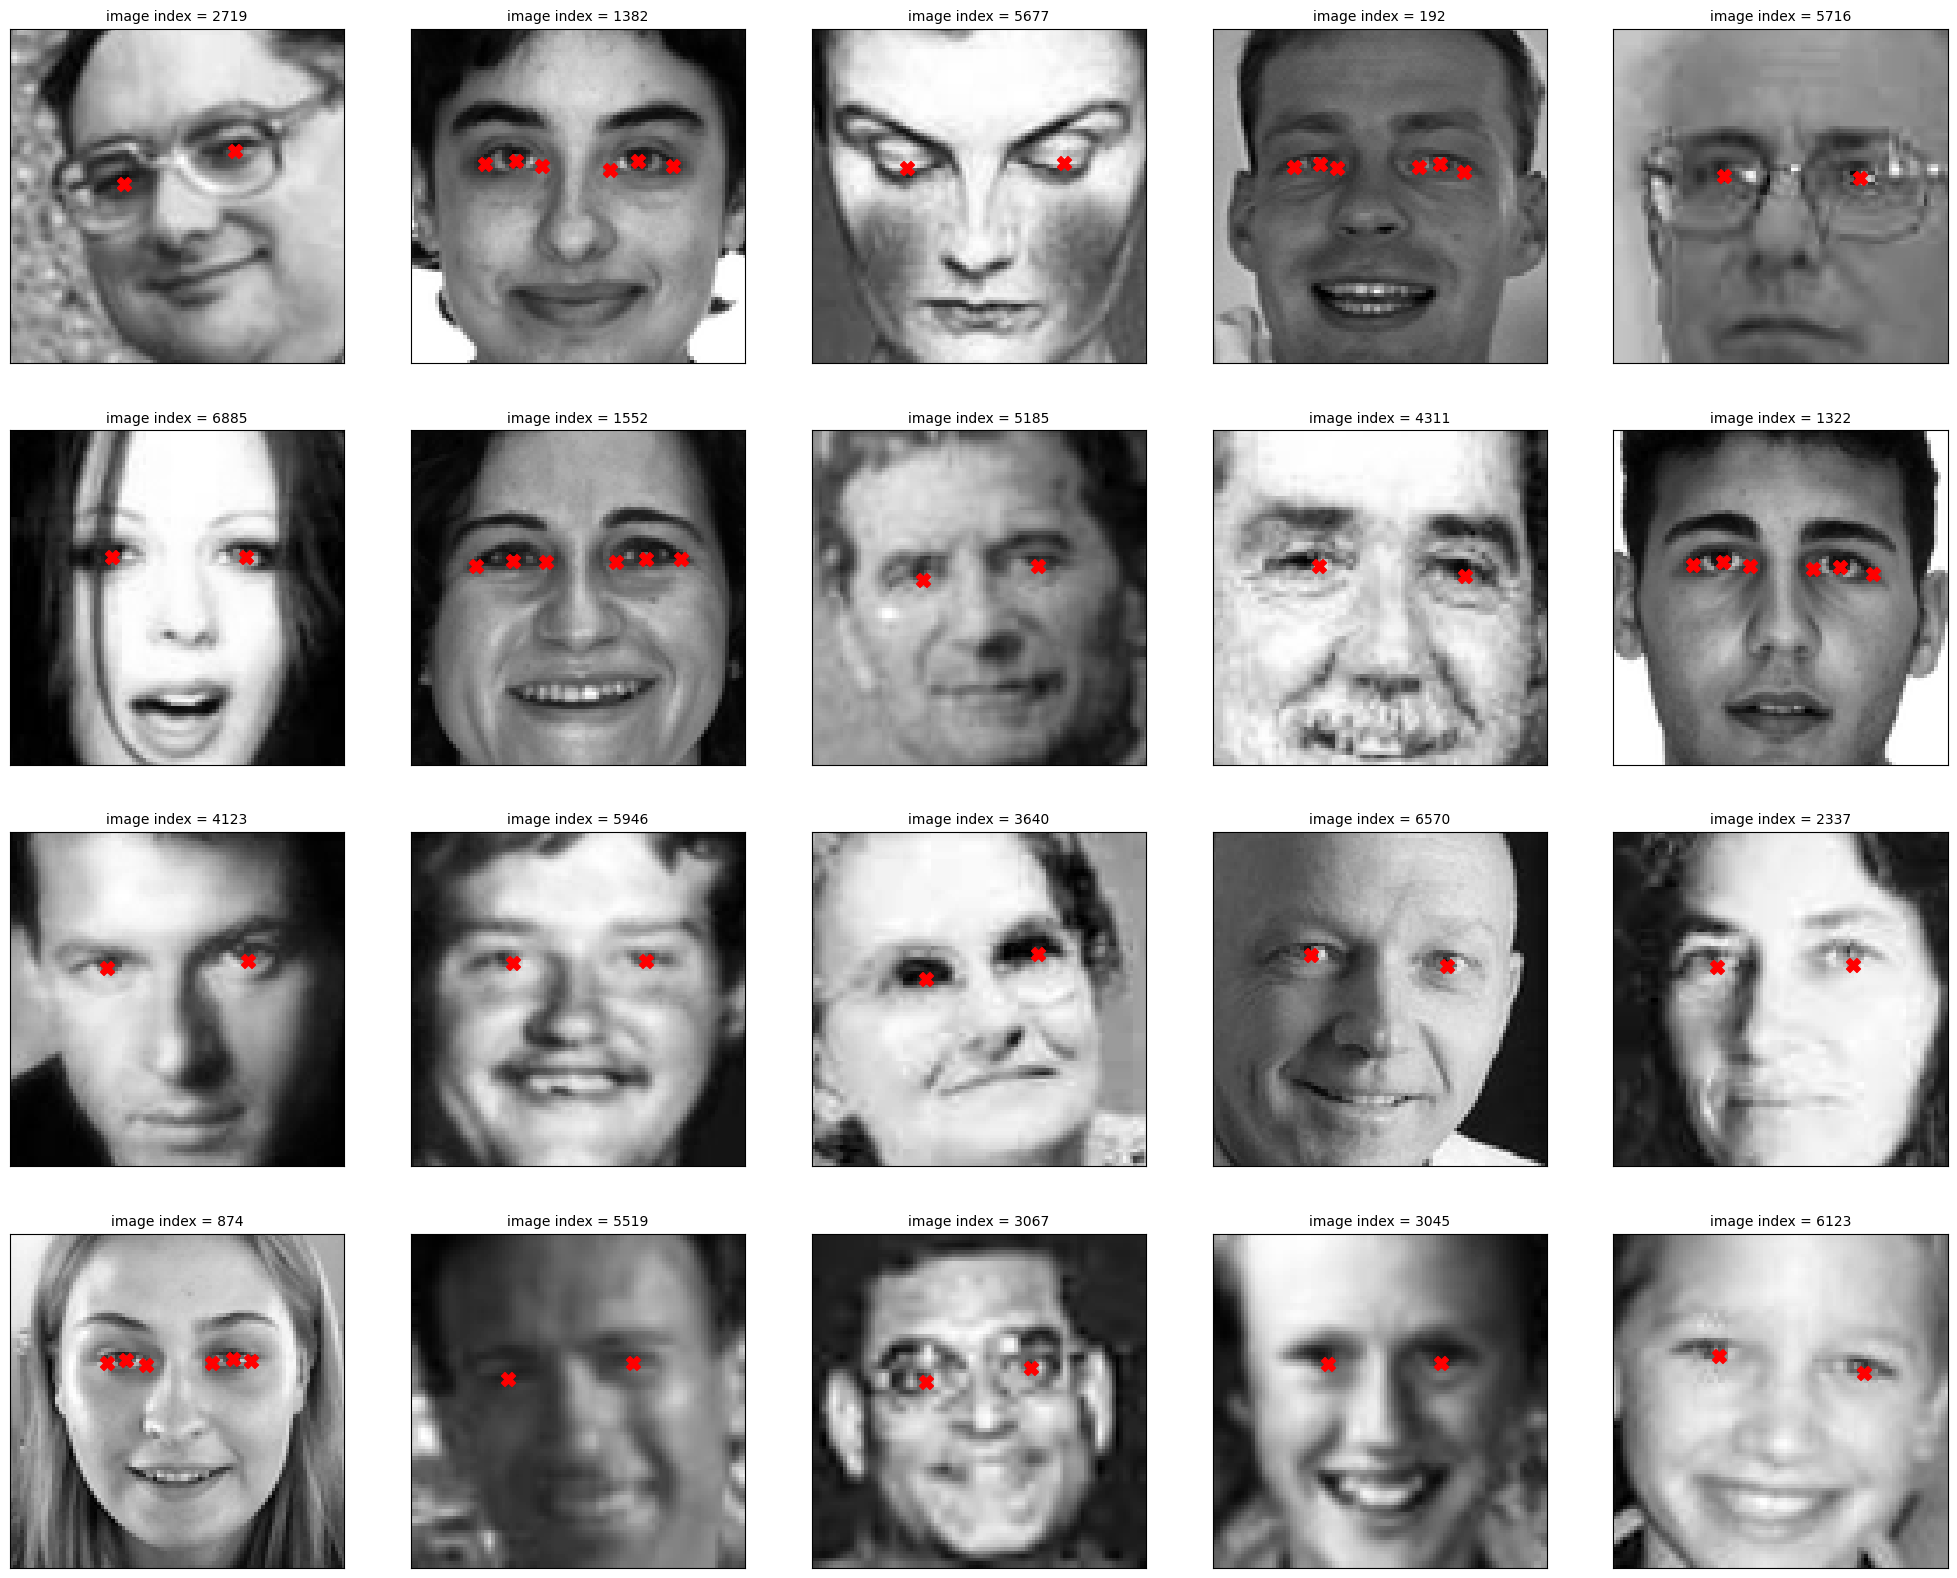

In [4]:
def plot_sample(X, Y, n_rows, n_cols, size=3):
    # sample n_rows*n_cols images
    i_rand = np.random.choice(Y.shape[0],n_rows*n_cols)
    n = 0
    fig, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=[n_cols*size,n_rows*size])
    for row in range(n_rows):
        for col in range(n_cols):
            ax[row,col].imshow(X[i_rand[n],:,:,0], cmap='gray')
            ax[row,col].scatter(Y[i_rand[n],0::2],Y[i_rand[n],1::2],marker='X',c='r',s=100)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' % i_rand[n], fontsize=10)
            n += 1

plot_sample(X, Y, 4, 5, 5)

As we can see there are a lot of missing values in the dataset. Let's try to fill them using some methods. 

In [5]:
# Normalize the dataset
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

# Fit the KNN imputer model on the normalized data
imputer = KNNImputer(n_neighbors=11)
Y_imputed = imputer.fit_transform(Y_scaled)

# Combine the imputed and non-missing parts of the dataset
Y = scaler.inverse_transform(Y_imputed)

Let's see how the data looks like after imputation.

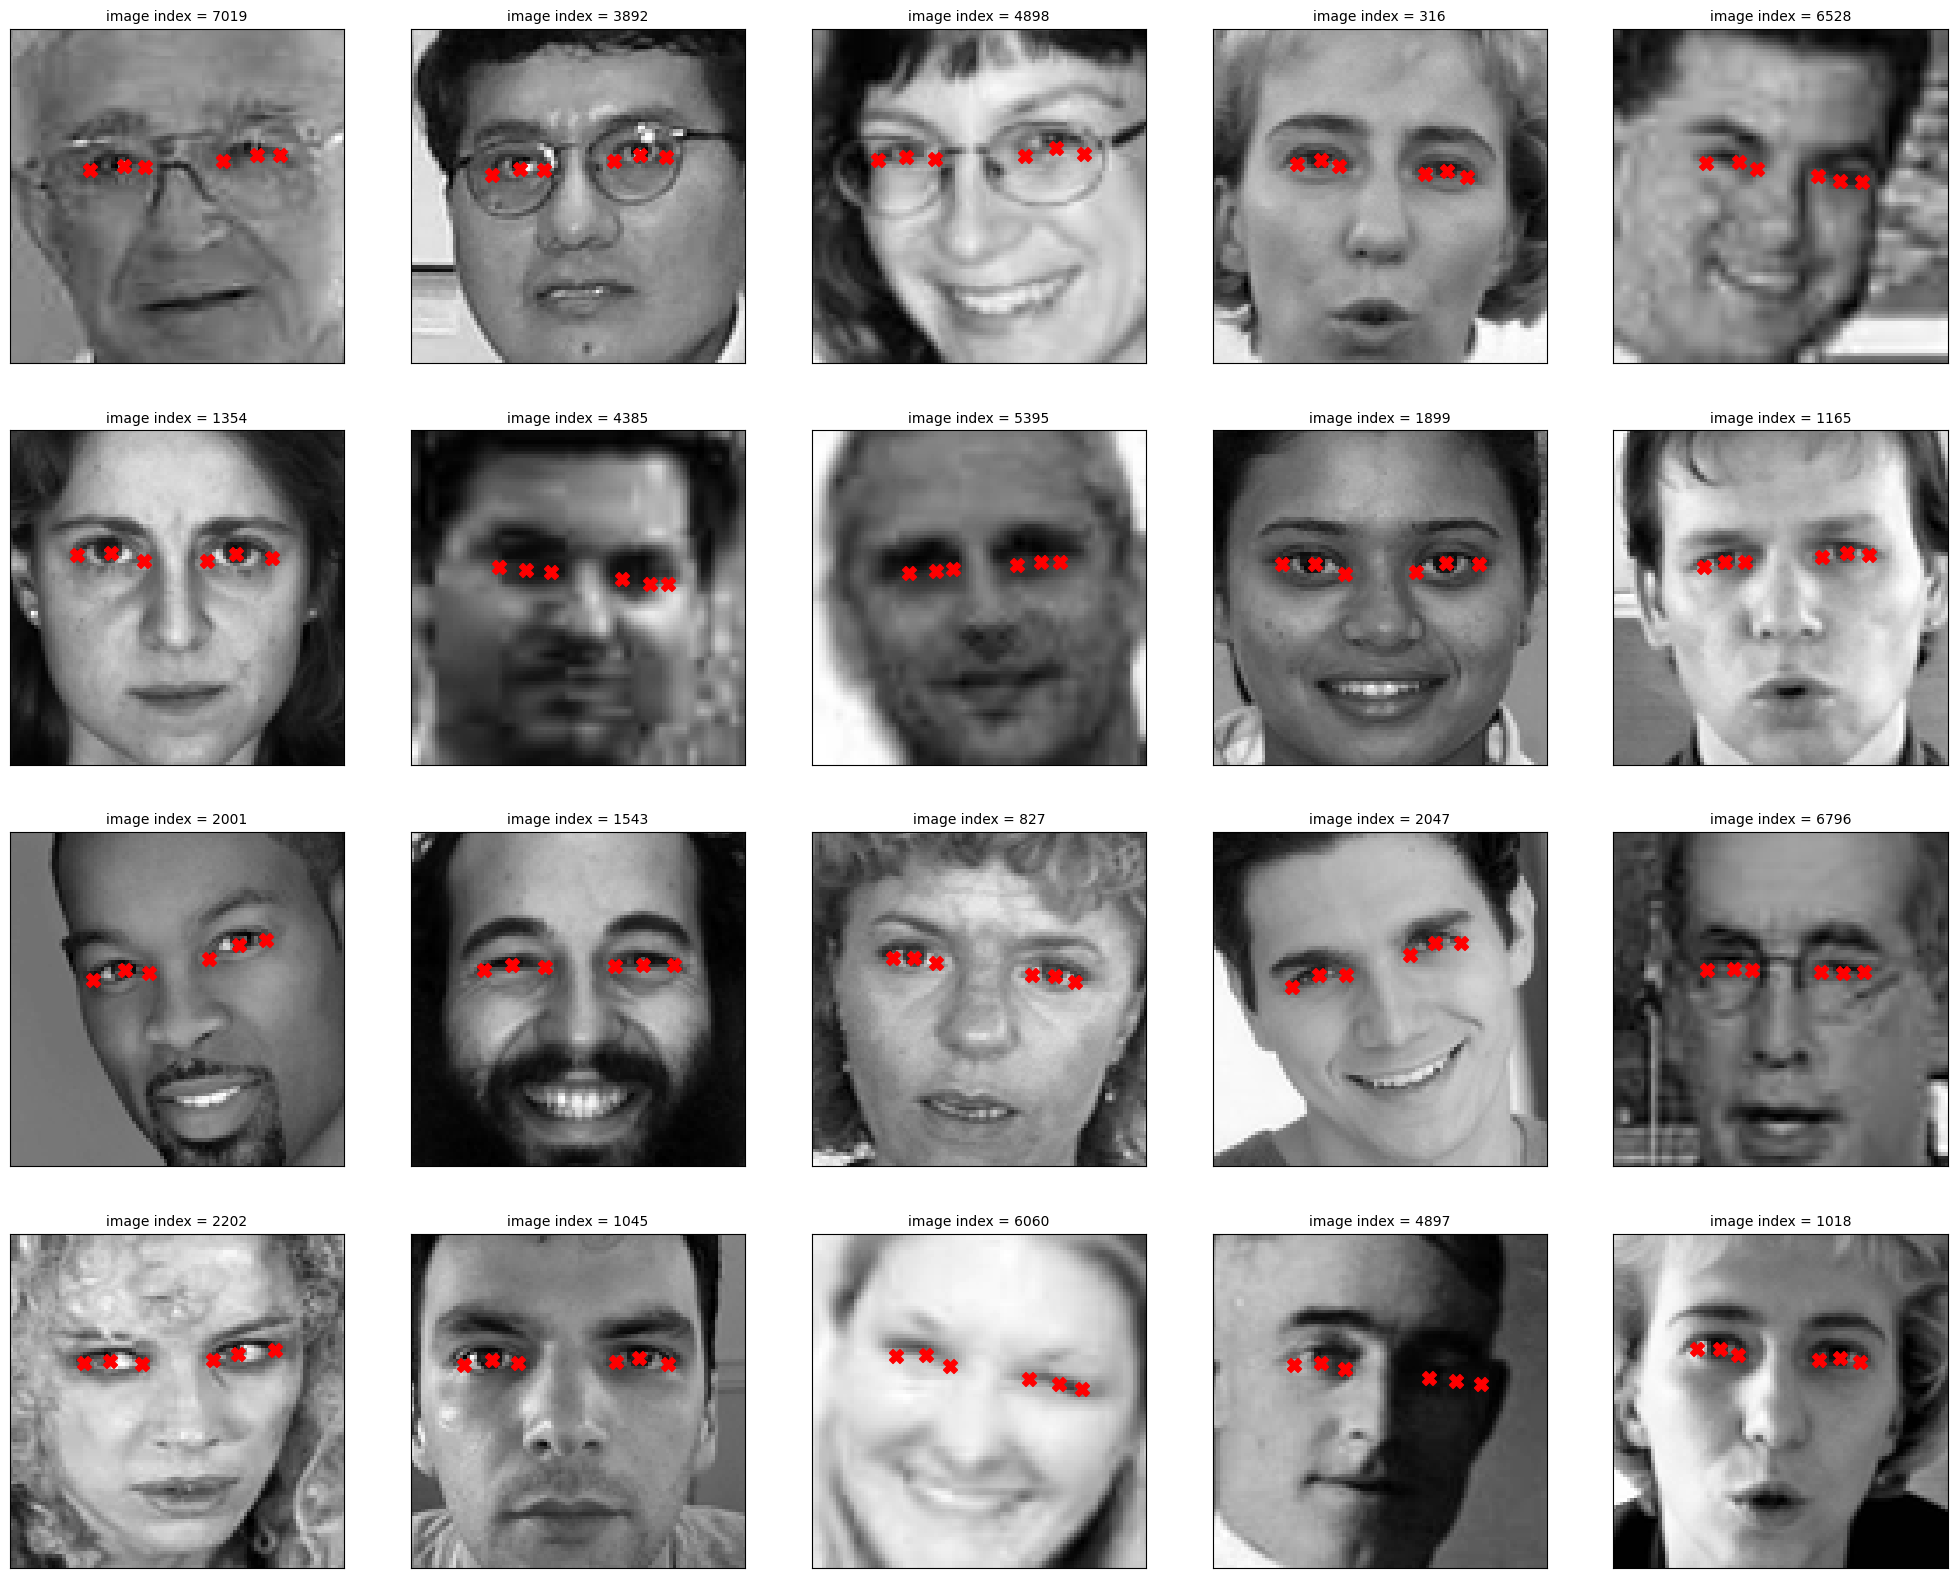

In [6]:
plot_sample(X, Y, 4, 5, 5)

## Data augmentation

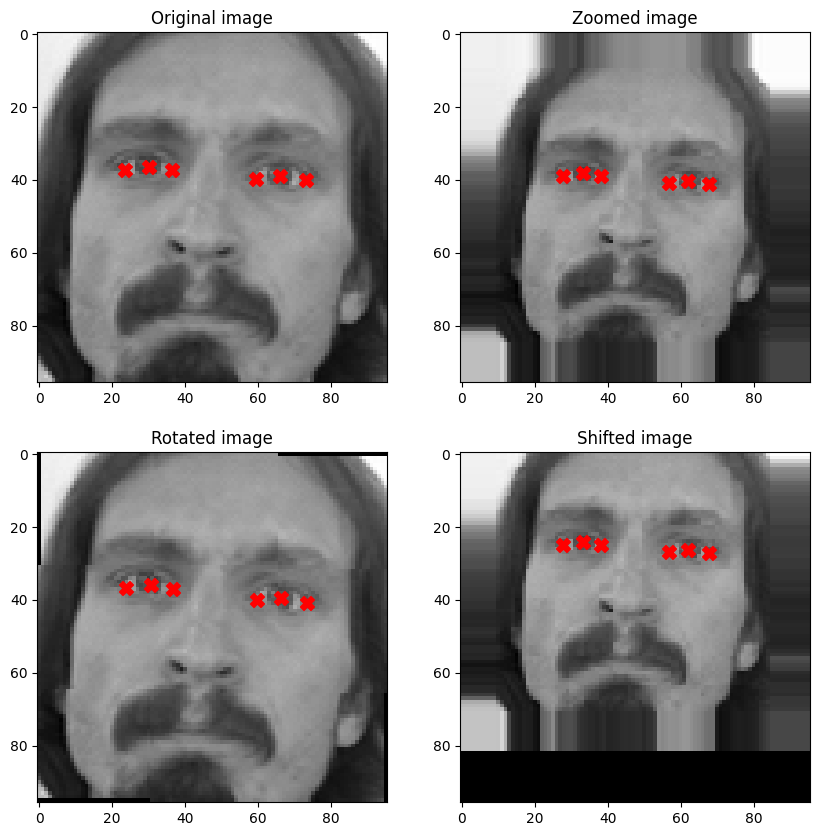

In [7]:
import cv2

# random zoom, fill mode is border replicate 
def random_zoom_out(image, landmarks, zoom_range=(0.5, 1.0)):
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    new_size = (int(image.shape[1] * zoom), int(image.shape[0] * zoom))
    diff = np.abs(new_size[0] - image.shape[1]) // 2
        
    image_zoomed = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    diff_2 = diff_3 = diff if np.abs(new_size[0] - image.shape[1]) % 2 == 0 else diff + 1

    image_zoomed = cv2.copyMakeBorder(image_zoomed, diff, diff_2, diff, diff_3, cv2.BORDER_REPLICATE)
    landmarks_zoomed = landmarks * new_size[0] / image.shape[1] + diff
    
    if image_zoomed.shape[0] != 96 or image_zoomed.shape[1] != 96:
        print('image_zoomed shape:', image_zoomed.shape)
    
    return image_zoomed, landmarks_zoomed

# random rotation
def random_rotation(image, landmarks, angle_range=(-10, 10)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    image_rotated = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_rotated = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        x = landmarks[i]
        y = landmarks[i + 1]
        landmarks_rotated[i] = rot_mat[0, 0] * x + rot_mat[0, 1] * y + rot_mat[0, 2]
        landmarks_rotated[i + 1] = rot_mat[1, 0] * x + rot_mat[1, 1] * y + rot_mat[1, 2]
    
    return image_rotated, landmarks_rotated

# random shift, choose a random shift value and a random direction
def random_shift(image, landmarks, shift_range=(0, 20)):
    shift = int(np.random.uniform(shift_range[0], shift_range[1]))
    direction = np.random.choice(['left', 'right', 'up', 'down'])
    
    if direction == 'left':
        shift_x = -shift
        shift_y = 0
    elif direction == 'right':
        shift_x = shift
        shift_y = 0
    elif direction == 'up':
        shift_x = 0
        shift_y = -shift
    else:
        shift_x = 0
        shift_y = shift
    
    shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    image_shifted = cv2.warpAffine(image, shift_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_shifted = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        landmarks_shifted[i] += shift_x
        landmarks_shifted[i + 1] += shift_y
    
    return image_shifted, landmarks_shifted

# examples
image = X[0]
landmarks = Y[0]
image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(0, 30))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image[:,:,0], cmap='gray')
ax[0][0].scatter(landmarks[0::2], landmarks[1::2], marker='X', c='r', s=100)
ax[0][0].set_title('Original image')

ax[0][1].imshow(image_zoomed, cmap='gray')
ax[0][1].scatter(landmarks_zoomed[0::2], landmarks_zoomed[1::2], marker='X', c='r', s=100)
ax[0][1].set_title('Zoomed image')

ax[1][0].imshow(image_rotated, cmap='gray')
ax[1][0].scatter(landmarks_rotated[0::2], landmarks_rotated[1::2], marker='X', c='r', s=100)
ax[1][0].set_title('Rotated image')

ax[1][1].imshow(image_shifted, cmap='gray')
ax[1][1].scatter(landmarks_shifted[0::2], landmarks_shifted[1::2], marker='X', c='r', s=100)
ax[1][1].set_title('Shifted image')

plt.show()

apply random zoom and rotation to the dataset

In [8]:
from joblib import Parallel, delayed

# Define a function that performs data augmentation on a single image
def augment_image(image, landmarks):
    image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
    image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
    image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(-30, 30))

    image_zoomed = np.expand_dims(image_zoomed, axis=2)
    image_rotated = np.expand_dims(image_rotated, axis=2)
    image_shifted = np.expand_dims(image_shifted, axis=2)

    return [image_zoomed, image_rotated, image_shifted], [landmarks_zoomed, landmarks_rotated, landmarks_shifted]

# Use joblib to parallelize the data augmentation
results = Parallel(n_jobs=-1)(delayed(augment_image)(X[i], Y[i]) for i in range(X.shape[0]))

# Extract the results
X_augmented = np.array([result[0] for result in results])
Y_augmented = np.array([result[1] for result in results])

# Flatten the results
X_augmented = np.concatenate(X_augmented, axis=0)
Y_augmented = np.concatenate(Y_augmented, axis=0)

Show the augmented dataset

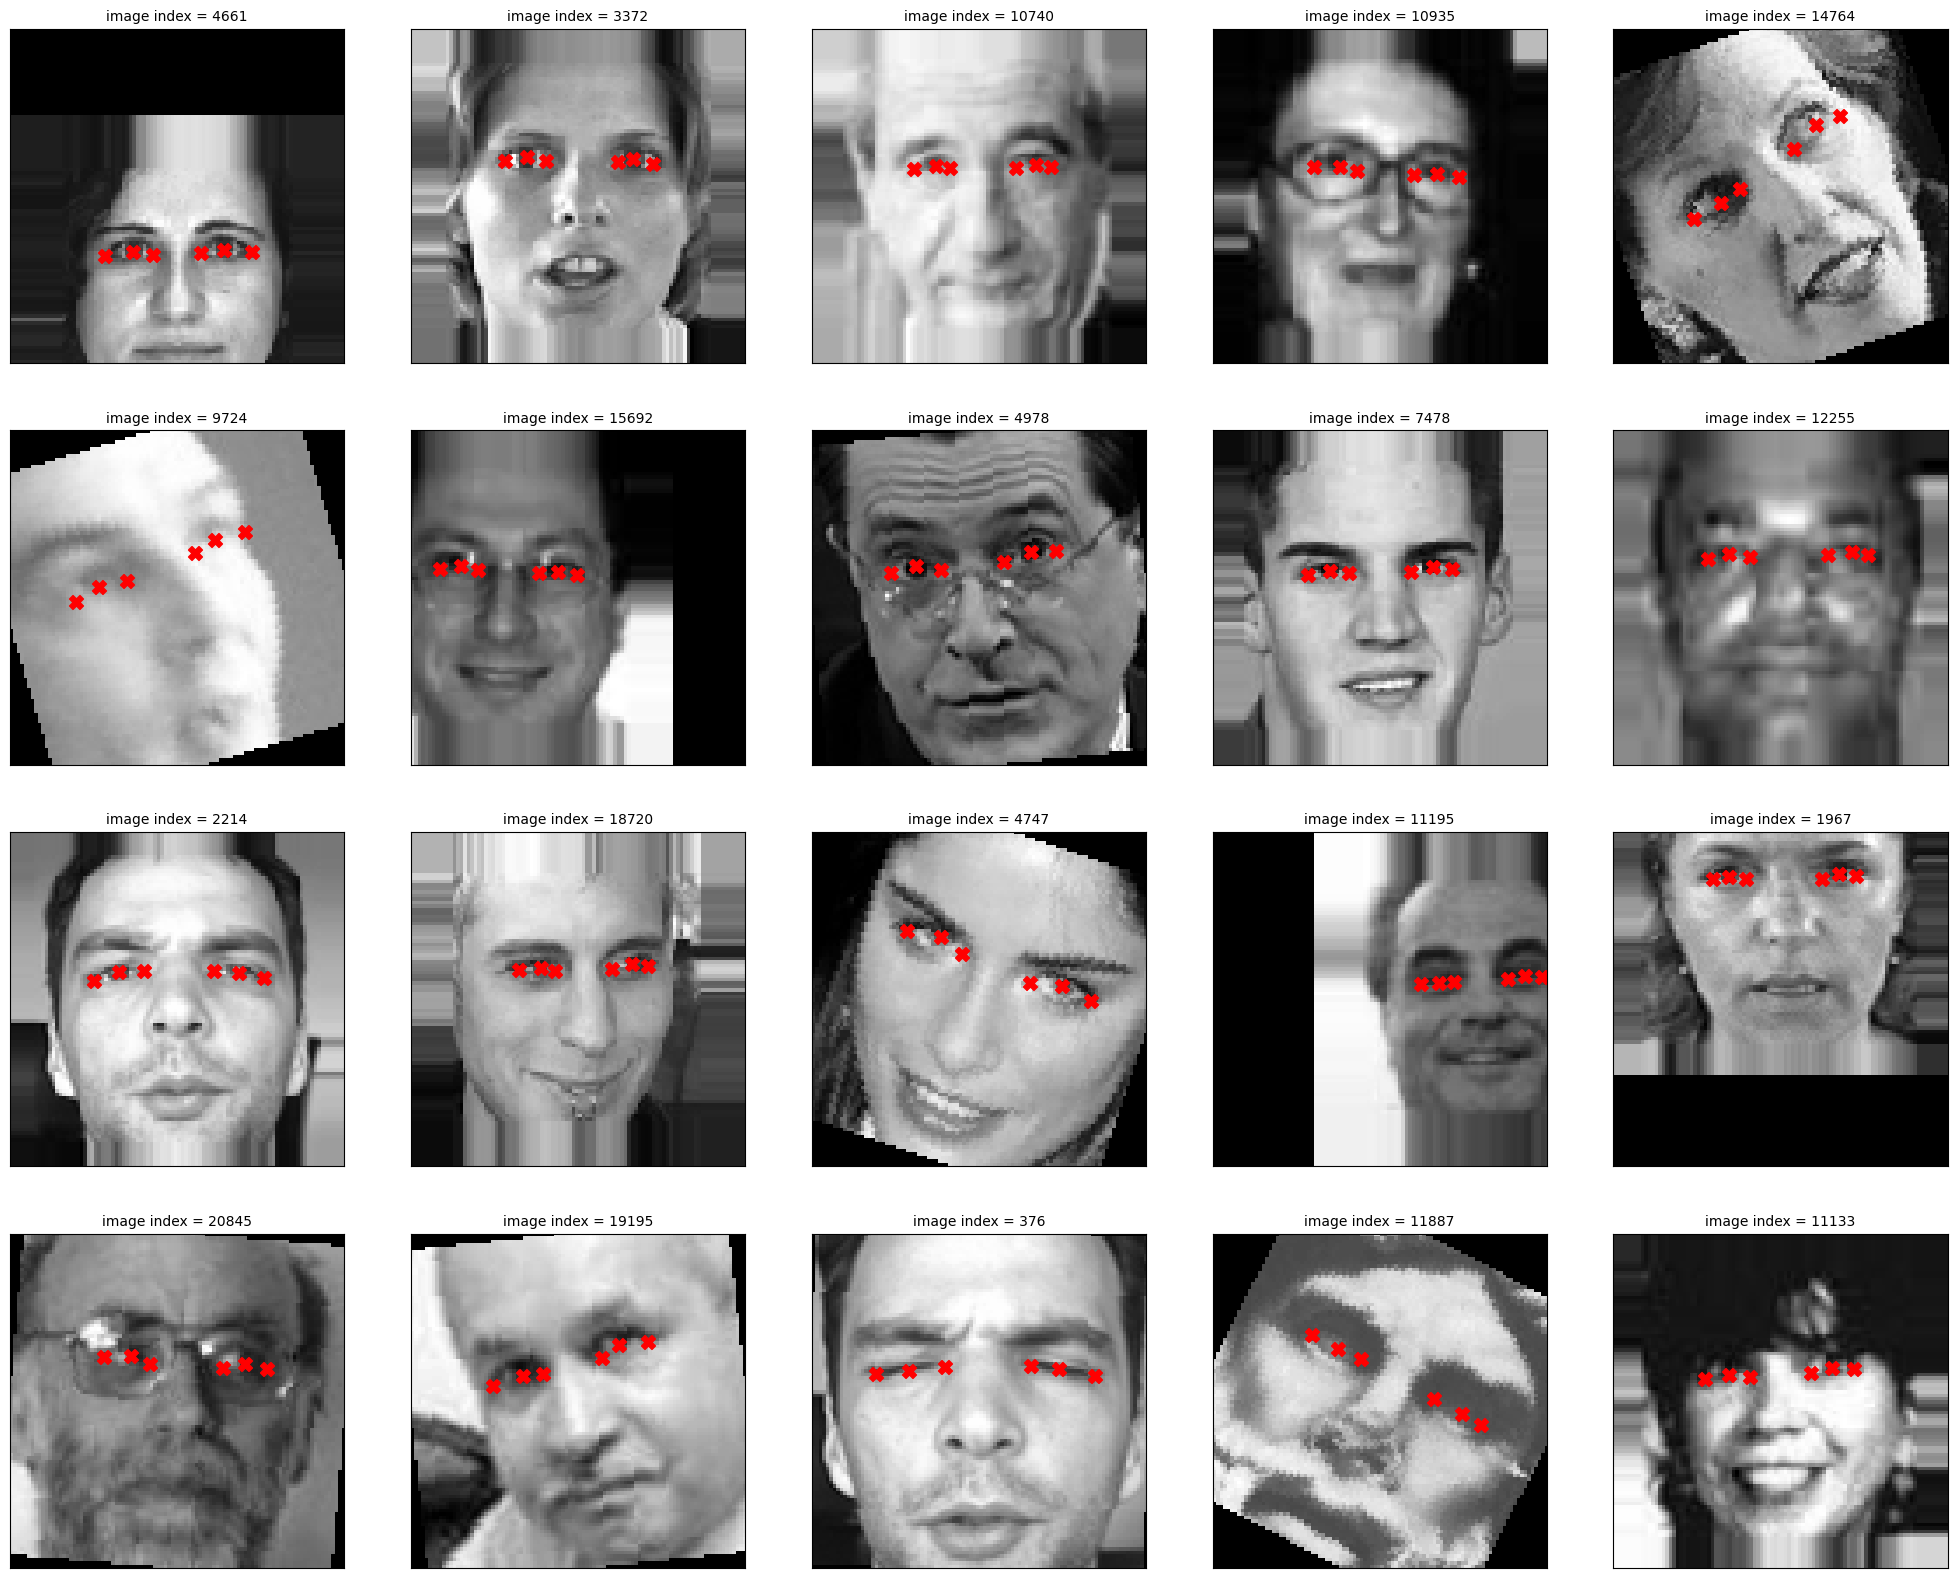

In [9]:
plot_sample(X_augmented, Y_augmented, 4, 5, 5)

## Train, test and validation split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)

X_train shape: (13503, 96, 96, 1)
Y_train shape: (13503, 12)
X_test shape: (4220, 96, 96, 1)
Y_test shape: (4220, 12)
X_val shape: (3376, 96, 96, 1)
Y_val shape: (3376, 12)


## Model

In [11]:
from tensorflow.keras.layers import Add

# Define the input layer
inputs = Input(shape=(96, 96, 1))

# Define the main path
x = BatchNormalization()(inputs)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

residual = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
residual = BatchNormalization()(residual)

x = Add()([x, residual])

# Continue with the main path
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

residual = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
residual = BatchNormalization()(residual)

x = Add()([x, residual])

# Continue with the main path
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

residual = Conv2D(256, (1, 1), padding='same', activation='relu')(x)
residual = BatchNormalization()(residual)

x = Add()([x, residual])

x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

residual = Conv2D(512, (1, 1), padding='same', activation='relu')(x)
residual = BatchNormalization()(residual)

x = Add()([x, residual])

x = Flatten()(x)
x = Dense(1028, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(12)(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 96, 1) │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        640 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 48,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │      4,160 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 48,    │          0 │ dropout[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ add[0][0]         │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 24,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │     16,512 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 24,    │          0 │ dropout_1[0][0],  │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │    295,168 │ batch_normalizat

 Total params: 20,920,340 (79.80 MB)

 Trainable params: 20,917,522 (79.79 MB)

 Non-trainable params: 2,818 (11.01 KB)

Compile the model

In [12]:
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy', 'mae'])

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

Train the model

In [13]:
history = model.fit(
    X_train, Y_train,
    batch_size=48,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/100


I0000 00:00:1718090802.150254    8539 service.cc:145] XLA service 0x7f60b0026380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718090802.150290    8539 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6


  3/282 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2188 - loss: 1722.2212 - mae: 36.2029   

I0000 00:00:1718090814.547041    8539 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7085 - loss: 158.7263 - mae: 8.0668

I0000 00:00:1718090835.922751    8778 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_276', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1718090835.984815    8772 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_276', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1718090836.005957    8784 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_276', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1718090837.639832    8814 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_276', 36 bytes spill stores, 36 bytes spill loads



282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.7090 - loss: 158.3930 - mae: 8.0580 - val_accuracy: 0.9810 - val_loss: 85.2990 - val_mae: 6.9077
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 26.4893 - mae: 3.9717 - val_accuracy: 0.9810 - val_loss: 269.8081 - val_mae: 14.4702
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9572 - loss: 22.3252 - mae: 3.6082 - val_accuracy: 0.9810 - val_loss: 156.8136 - val_mae: 10.9739
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9693 - loss: 18.7842 - mae: 3.2814 - val_accuracy: 0.9810 - val_loss: 61.2533 - val_mae: 6.1471
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9719 - loss: 15.9463 - mae: 3.0333 - val_accuracy: 0.9754 - val_loss: 14.5517 - val_mae: 3.1157
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9704 - loss: 16.8476 - mae: 3.0888 - val_accuracy: 0.9810 - val_loss: 41.4501 - val_mae: 4.4103
Epoch 7/100
282/2

Plot the loss

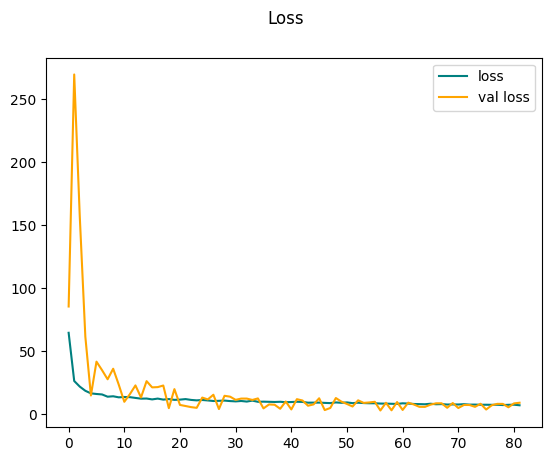

In [14]:
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

Save the model

In [21]:
model.save('./models/facial_landmark_detection_residual.h5')

## Test the model
load the model

In [22]:
model = tf.keras.models.load_model('./models/facial_landmark_detection_residual.h5')
model.evaluate(X_test, Y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9820 - loss: 2.2519 - mean_absolute_error: 1.0830


[2.283337116241455, 0.9822275042533875, 1.0858854055404663]

Let's see how the model performs on the test set.

132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


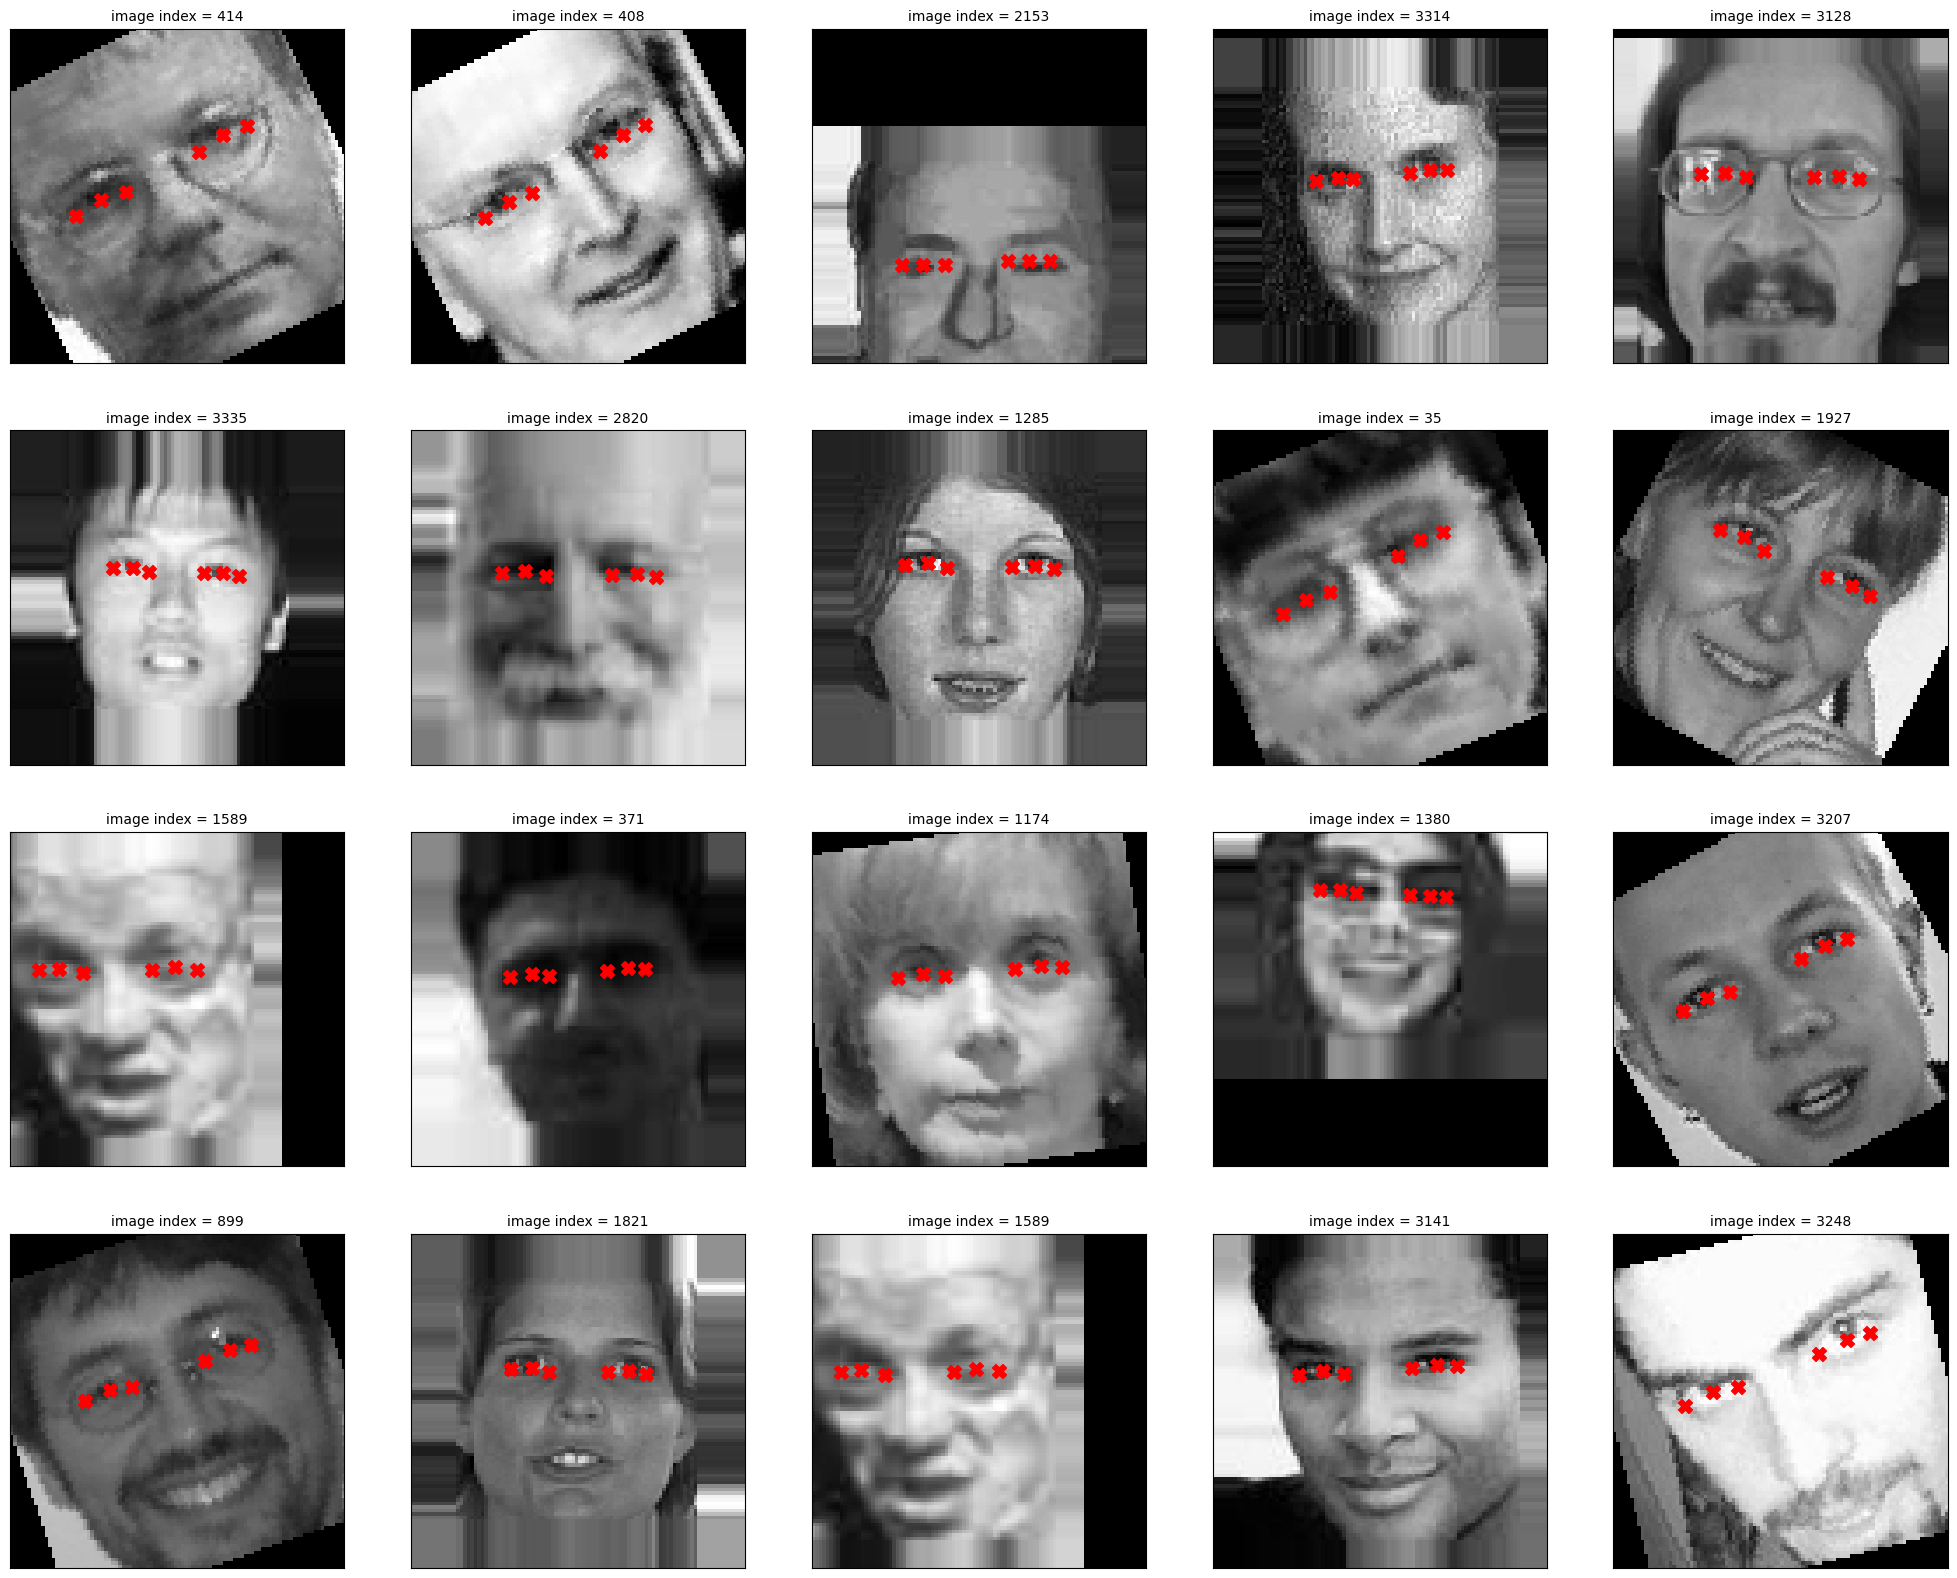

In [23]:
Y_pred = model.predict(X_test)

plot_sample(X_test, Y_pred, 4, 5, 5)

Test the model on CASIA-Iris-Distance dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[[65.84129  38.088997 30.384436 36.862938 58.038563 38.46546  71.98583
  38.966763 37.048546 38.210262 23.093267 37.365303]]


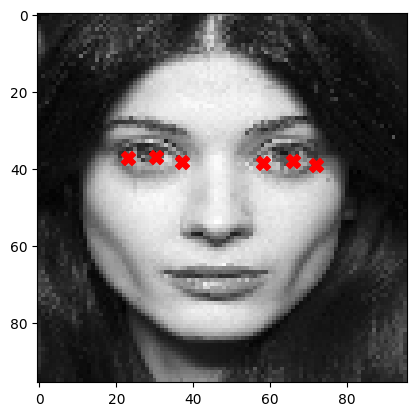

In [24]:
test_image = cv2.imread('./dataset/test_face.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[63.09339  33.221275 32.343193 33.832413 56.469822 34.177967 68.40106
  33.873573 37.89079  34.92558  25.72287  34.88983 ]]


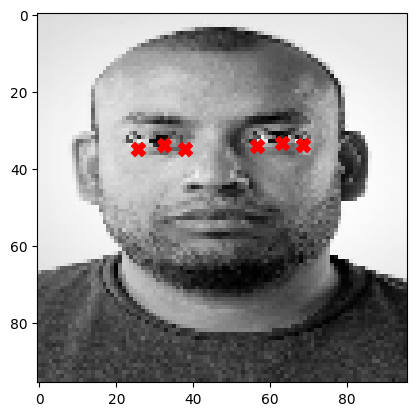

In [25]:
test_image = cv2.imread('./dataset/test_face_2.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[68.45236  38.92894  28.08681  38.002876 59.571877 39.34112  75.23078
  39.718586 35.77876  39.35793  20.062466 38.59906 ]]


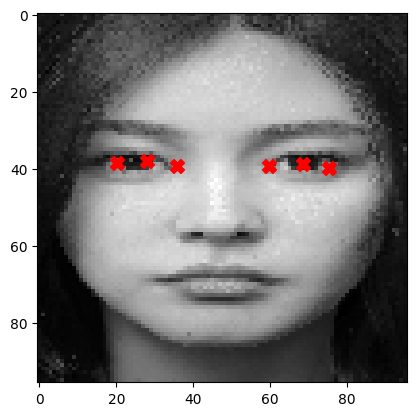

In [26]:
test_image = cv2.imread('./dataset/test_face_3.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()